In [1]:
#######  importar as bibliotecas ##########  

#pip install -U textblob
from textblob import TextBlob
import pandas as pd
import numpy as np
from pprint import pprint
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#!{sys.executable} 
#-m pip install contractions

import re
import collections
import random
import string
import sklearn
import contractions


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist
from nltk import word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
import nltk.stem as stem
from nltk.corpus import stopwords
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
import unicodedata
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
from pandas import DataFrame


### classificadores ####
from textblob.classifiers import NaiveBayesClassifier

from sklearn.naive_bayes import (
    BernoulliNB,
    ComplementNB,
    MultinomialNB)
from nltk.classify import NaiveBayesClassifier as nbc
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from nltk.metrics import scores
from sklearn.metrics import classification_report
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV

In [2]:
#importar a base de dados 
treino=pd.read_csv("/Users/Guilherme/Desktop/trabalho/train.csv")
teste=pd.read_csv("/Users/Guilherme/Desktop/trabalho/test.csv")
random.seed(0)

array([<AxesSubplot:ylabel='Treino'>, <AxesSubplot:ylabel='Teste'>],
      dtype=object)

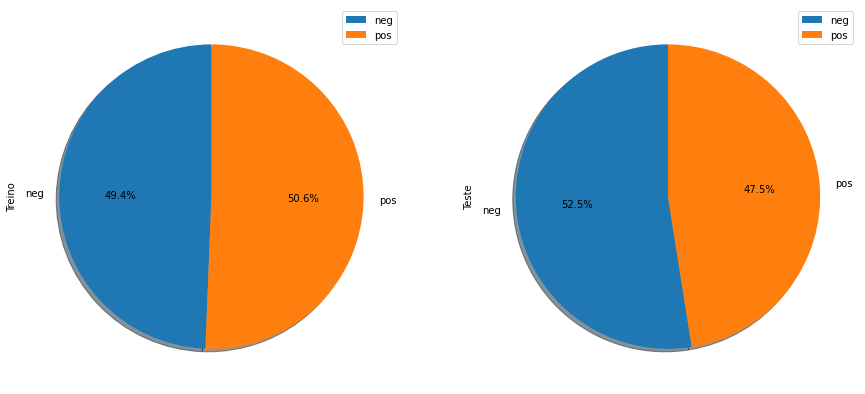

In [3]:
### Gráficos distribuição sentimentos nos conjuntos de treino e teste
counts_teste= [(teste["Sentiment"]=="POS").sum(),(teste["Sentiment"]=="NEG").sum()]
counts_treino= [(treino["Sentiment"]=="POS").sum(),(treino["Sentiment"]=="NEG").sum()]
data = {'Treino': [(treino["Sentiment"]=="POS").sum(), (treino["Sentiment"]=="NEG").sum()]
        ,'Teste': [(teste["Sentiment"]=="POS").sum(), (teste["Sentiment"]=="NEG").sum()]
        ,"Sentiment":["pos","neg"]}
df = pd.DataFrame(data)
df.groupby(['Sentiment']).sum().plot(kind='pie', subplots=True, shadow = True,startangle=90,figsize=(15,10),autopct='%1.1f%%')

<h3>Funções</h3>

In [4]:
### Baseado nos slides da disciplina de Text Mining

classifiers = {
    "MultinomialNB": MultinomialNB(),"BernoulliNB": BernoulliNB()
}

# Função para classificar o dataset das features --> NLTK
###################################################################

def train_and_evaluate1(train_set, test_set):
    for name, sklearn_classifier in classifiers.items():
        classifier = nltk.classify.SklearnClassifier(sklearn_classifier)
        classifier.train(train_set)
        accuracy = nltk.classify.accuracy(classifier, train_set)
        accuracy1 = nltk.classify.accuracy(classifier, test_set)
        print("treino",F"{accuracy:.2%} - {name}")
        print("teste",F"{accuracy1:.2%} - {name}")

In [5]:
# Baseado em: https://realpython.com/python-nltk-sentiment-analysis/

### Otimização dos parâmetros
###################################################################

tuned_parametersSVC = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4,'scale'], 'C': [1, 10, 100, 1000]},
                    {'kernel': ['poly'], 'gamma': [1e-3, 1e-4,'scale'], 'C': [1, 10, 100, 1000]}]

tuned_parametersMLP = [{'max_iter':[500],'learning_rate':['constant', 'invscaling', 'adaptive'],
                     'learning_rate_init':[0.001,0.005,0.01,0.1]}]

tuned_parametersLOG= [{'solver':['liblinear'],'C': [1, 10, 100, 1000],'max_iter':[100,500,1000]}]

tuned_parametersRANDTREE=[{'n_estimators':[100,500,1000],'max_depth':[1,2,3,4],'max_features':["auto", "sqrt", "log2"]}]


classifiers2 = {"C-Support Vector Classification": GridSearchCV(SVC(), param_grid =tuned_parametersSVC,refit=True,cv=10),
               "MLPClassifier":GridSearchCV(MLPClassifier(), param_grid =tuned_parametersMLP,refit=True,cv=10),
               "LogisticRegression":GridSearchCV(LogisticRegression(),param_grid =tuned_parametersLOG,refit=True,cv=10),
               "RandomForestClassifier":GridSearchCV(RandomForestClassifier(),param_grid =tuned_parametersRANDTREE,refit=True,cv=10),
               }



# Função para classificação dos modelos finais
###################################################################
def train_and_evaluate2(classifiers2):
    for name, sklearn_classifier in classifiers2.items():
        classifier = sklearn_classifier
        classifier.fit(treino_X,treino_list_sent)
        print(classifier.best_params_)
        classifier.best_score_
        params=classifier.cv_results_['params']
        means = classifier.cv_results_['mean_test_score']
        stds = classifier.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, classifier.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))
        pred=classifier.predict(treino_X)
        pred2=classifier.predict(teste_X)
        print("Mislabeled points: {} out of {} - {}".format((treino_list_sent!=pred).sum(), treino_X.shape[0], name))
        print("Mislabeled points: {} out of {} - {}".format((teste_list_sent!=pred2).sum(), teste_X.shape[0], name))
        print("Accuracy: {} - {}".format(metrics.accuracy_score(treino_list_sent, pred), name))
        print("Accuracy: {} - {}".format(metrics.accuracy_score(teste_list_sent, pred2), name))
        #print("Precision:{} - {}".format(metrics.precision_score(treino_list_sent, pred, average="macro"),name))
        #print("Precision:{} - {}".format(metrics.precision_score(teste_list_sent, pred2, average="macro"),name))
        #print("Recall: {} - {}".format(metrics.recall_score(treino_list_sent, pred, average="macro"),name))
        #print("Recall: {} - {}".format(metrics.recall_score(teste_list_sent, pred2, average="macro"),name))
        #print("F1-measure: {} - {}".format(metrics.f1_score(treino_list_sent, pred, average="macro"),name))
        #print("F1-measure: {} - {}".format(metrics.f1_score(teste_list_sent, pred2, average="macro"),name))

In [6]:
classifiers1 = {
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB(),
    "MultinomialNB": MultinomialNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(solver='liblinear'),
    "MLPClassifier": MLPClassifier(max_iter=1000),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "C-Support Vector Classification": SVC(),
}


# Função para classificar o pré-processamento, skillit_learn
def train_and_evaluate3(classifiers1):
    for name, sklearn_classifier in classifiers1.items():
        classifier = sklearn_classifier
        classifier.fit(treino_X,treino_list_sent)
        pred=classifier.predict(treino_X)
        pred2=classifier.predict(teste_X)
        print("Mislabeled points: {} out of {} - {}".format((treino_list_sent!=pred).sum(), treino_X.shape[0], name))
        print("Mislabeled points: {} out of {} - {}".format((teste_list_sent!=pred2).sum(), teste_X.shape[0], name))
        print("Accuracy: {} - {}".format(metrics.accuracy_score(treino_list_sent, pred), name))
        print("Accuracy: {} - {}".format(metrics.accuracy_score(teste_list_sent, pred2), name))
        #print("Precision:{} - {}".format(metrics.precision_score(treino_list_sent, pred, average="macro"),name))
        #print("Precision:{} - {}".format(metrics.precision_score(teste_list_sent, pred2, average="macro"),name))
        #print("Recall: {} - {}".format(metrics.recall_score(treino_list_sent, pred, average="macro"),name))
        #print("Recall: {} - {}".format(metrics.recall_score(teste_list_sent, pred2, average="macro"),name))
        #print("F1-measure: {} - {}".format(metrics.f1_score(treino_list_sent, pred, average="macro"),name))
        #print("F1-measure: {} - {}".format(metrics.f1_score(teste_list_sent, pred2, average="macro"),name))

In [7]:
# Baseado em: https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html

# Função para fazer merge de 2 listas que ficam no formato de tuplo
def merge(list1, list2):
      
    merged_list = tuple(zip(list1, list2)) 
    return merged_list


##### Função para a eliminação dos acentos
############################################

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

##### Função para a eliminação dos carateres especiais e digitos
###################################################################


def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text


##### Função para o Stemming
############################################

def simple_stemmer(text):
    ps = nltk.snowball.SnowballStemmer("english")
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

##### Função para o Lemming
############################################
def simple_Lemmatizer(text):
    lem = WordNetLemmatizer()
    text = ' '.join([lem.lemmatize(word) for word in text.split()])
    return text

##### Função para remoção das stopwords
############################################

tokenizer = ToktokTokenizer()
def remove_stopwords(text, is_lower_case=True):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

##### Função para seleção das features
############################################
def docs2features(docs, selected_features):
    features = []
    for doc_feature_counts, tag in docs:
        features.append(({f:doc_feature_counts[f] for f in selected_features}, tag))
    return features


#### Função para testar a accuracy da aplicação do léxico de sentimentos
########################################################################
def accuracy_lexico(review):
    classificacao=[] ## Tuplo comentário-sentimento
    for x in review:
        if x>=0:
            classificacao.append("POS")
        if x<0:
            classificacao.append("NEG")     
    classificacao #classificacao - lista com a classificação de sentimento
    # Driver code
    classificacao_sent=merge(teste_list,classificacao) #classificacao_sent # tuplo com frase e sentimento
    
    i=0
    total_acertos=0
    for x in teste_list_sent:
        if x == classificacao[i]:
            total_acertos=total_acertos+1
        i=i+1
    print("Total de comentários -->", len(teste_list))
    print("Total de sentimentos bem identificados-->", total_acertos)
    print("Accuracy -->", total_acertos/len(teste_list))

<h1> I.2. PREPARAÇÃO DOS DADOS E CRIAÇÃO DE UMA BASELINE </h1>

<h2> Conversão dos dados </h2>

In [8]:
# Conjunto Treino: Conversão das colunas text e sentiment do dataset para lista
treino_list=treino["Text"].to_list() # passagem dos comentários para lista
treino_list_sent=treino["Sentiment"].to_list() # passagem dos sentimentos/tag para lista
#
#treino_list # todos os comentários estão separados por vírgula, no formato string

# Conjunto Teste: Conversão das colunas text e sentiment do dataset para lista
teste_list=teste["Text"].to_list()
teste_list_sent=teste["Sentiment"].to_list()
#treino_list_sent

<h2> Criação da Baseline </h2>

In [9]:
### Baseado nos slides da disciplina de Text Mining

# Vectorização
vectorizer = CountVectorizer() #The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary. 
treino_X = vectorizer.fit_transform(treino_list) # Learn the vocabulary dictionary and return document-term matrix.
teste_X = vectorizer.transform(teste_list) # Transform documents to document-term matrix.

train_and_evaluate3(classifiers)

Mislabeled points: 37 out of 1600 - MultinomialNB
Mislabeled points: 51 out of 400 - MultinomialNB
Accuracy: 0.976875 - MultinomialNB
Accuracy: 0.8725 - MultinomialNB
Mislabeled points: 25 out of 1600 - BernoulliNB
Mislabeled points: 44 out of 400 - BernoulliNB
Accuracy: 0.984375 - BernoulliNB
Accuracy: 0.89 - BernoulliNB


<h1> 1.3 APLICAÇÃO DE UM LÉXICO DE SENTIMENTOS </h1>

In [10]:
### Baseado nos slides da disciplina de Text Mining

# Importar o léxico - leitura linha a linha
import csv
lexicon={}
with open("/Users/Guilherme/Desktop/trabalho/NCR-lexicon.csv", encoding="utf-8") as csvfile:
    reader = csv.DictReader(csvfile, delimiter="," ) #assigns an index to each item in an iterable object that can be used to reference the item later
    for i, d in enumerate(reader):
        lexicon[d["English"]]=int(d["Positive"]) - int(d["Negative"])
#lexicon

<h2>a) Aplicação do léxico de sentimentos s/ tratamento da negação</h2>

<h3> A.1 - Cálculo da Accuracy sem o tratamento da negação </h3>

In [11]:
### Ciclo que retorna os valores de lexicon, em que cada frase é uma lista
teste_list_tok2=[]
for x in teste_list:
    teste_list_tok1=word_tokenize(x.lower())
    teste_list_tok2.append(teste_list_tok1)

# CICLO PARA APLICAÇÃO DO LEXICON
contador_pos=0
contador_neg=0
review=[]
contador_total=0
comentario=teste_list_tok2
for x in range(len(comentario)):
        for y in range(len(comentario[x])):
            if comentario[x][y] in lexicon:
                a=lexicon[comentario[x][y]]
                #print(a)
                contador_pos=0
                contador_neg=0
                contador_total=0
                if a >=0:
                    contador_pos=contador_pos+1
                if a <0:
                    contador_neg=contador_neg+1  
            contador_total=contador_pos-contador_neg
        if contador_total >=0:
            contador_total=1
        else:
            contador_total=-1
        review.append(contador_total)

#review # --> devolve uma lista com valores de -1 a 1

#len(review) # 400 elementos

accuracy_lexico(review)


Total de comentários --> 400
Total de sentimentos bem identificados--> 200
Accuracy --> 0.5


<h2>b) Aplicação do léxico de sentimentos c/ tratamento da negação</h2>

<h2>Tratamento da Negação </h2>
<h3> Alteração das contrações n't para not </h3>

In [12]:
### Baseado em: https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/

### Alteração das contrações n't para not
expanded_words=[]
expanded_words_coment=[]
for x in teste_list:
    for y in x.split():  
        expanded_words.append(contractions.fix(y))
    expanded_words_coment.append(' '.join(list(expanded_words))) # Devolve uma lista onde os comentários estão em string
    expanded_words=[]

<h3> A.2 - Aplicação do léxico de sentimentos c/ tratamento da negação</h3>

In [13]:
### Ciclo que retorna os valores de lexicon, em que cada comentário é uma lista
teste_list_tok4=[]
for x in expanded_words_coment:
    teste_list_tok3=word_tokenize(x.lower())
    teste_list_tok4.append(teste_list_tok3)

# CICLO PARA O LEXICON COM TRATAMENTO DA NEGAÇÃO
### Se a palavra not for detetada, a palavra seguinte passa a negativa (-1) ou positiva (1)
contador_pos=0
contador_neg=0
review3=[]
contador_total=0
comentario=teste_list_tok4
for x in range(len(comentario)):
    contador_not=0
    for y in range(len(comentario[x])):
        if comentario[x][y]=="not":
            contador_not=1
        if comentario[x][y] in lexicon:
            a=lexicon[comentario[x][y]]
            #print(a)
            contador_pos=0
            contador_neg=0
            contador_total=0
            if contador_not==1 and (a>0 or a<0):
                contador_pos=-1
                contador_neg=1
                contador_not=0
            if a >=0:
                contador_pos=contador_pos+1
            if a <0:
                contador_neg=contador_neg+1  
        contador_total=contador_pos-contador_neg
    if contador_total >=0:
        contador_total=1
    else:
        contador_total=-1
    review3.append(contador_total)  # --> devolve uma lista com valores de -1 a 1

#review3

#len(review3) 400 listas

accuracy_lexico(review3)

Total de comentários --> 400
Total de sentimentos bem identificados--> 208
Accuracy --> 0.52


<h3> A.3 - Aplicação do léxico de sentimentos c/ tratamento da negação +
remoção das stopwords, carateres especiais, acentos e digitos </h3>

In [14]:
teste_lex_spe=[]
teste_lex_clean=[]
teste_lex_stop=[]
for x in expanded_words_coment:
    teste_lex_spe.append(remove_special_characters(x,remove_digits=True))
    for y in teste_lex_spe:
        teste_lex_clean.append(remove_accented_chars(y))
        for z in teste_lex_clean:
            teste_lex_stop.append(remove_stopwords(z.lower()))
        teste_lex_clean=[]
    teste_lex_spe=[]


# CICLO PARA O LEXICON COM TRATAMENTO DA NEGAÇÃO
### Se a palavra not for detetada, a palavra seguinte passa a negativa (-1) ou positiva (1)
teste_list_tok6=[]
for x in teste_lex_stop:
    teste_list_tok5=word_tokenize(x)
    teste_list_tok6.append(teste_list_tok5)


contador_pos=0
contador_neg=0
review4=[]
contador_total=0
comentario=teste_list_tok6
for x in range(len(comentario)):
    contador_not=0
    for y in range(len(comentario[x])):
        if comentario[x][y]=="not":
            contador_not=1
        if comentario[x][y] in lexicon:
            a=lexicon[comentario[x][y]]
            #print(a)
            contador_pos=0
            contador_neg=0
            contador_total=0
            if contador_not==1 and (a>0 or a<0):
                contador_pos=-1
                contador_neg=1
                contador_not=0
            if a >=0:
                contador_pos=contador_pos+1
            if a <0:
                contador_neg=contador_neg+1  
        contador_total=contador_pos-contador_neg
    if contador_total >=0:
        contador_total=1
    else:
        contador_total=-1
    review4.append(contador_total)   # --> devolve uma lista com valores de -1 a 1

#review4

#len(review4) #400 listas
accuracy_lexico(review4)


Total de comentários --> 400
Total de sentimentos bem identificados--> 208
Accuracy --> 0.52


<h1> PART II Aprendizagem Automática </h1>

<h2> PRÉ-PROCESSAMENTO </h2>

<h3> <b> B.1 - Stemming</b></h3>

In [15]:
# Baseado em: https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html

# Aplicação do Stemming ao conjunto de treino
treino_list_stem=[]
for x in treino_list:
    treino_list_stem.append(simple_stemmer(x)) # Devolve uma lista onde os comentários estão em string
    
# Aplicação do Stemming ao conjunto de teste
teste_list_stem=[]
for x in teste_list:
    teste_list_stem.append(simple_stemmer(x)) # Devolve uma lista onde os comentários estão em string

# Vectorização
vectorizer = CountVectorizer() #The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary. 
treino_X = vectorizer.fit_transform(treino_list_stem)# Learn the vocabulary dictionary and return document-term matrix.
teste_X = vectorizer.transform(teste_list_stem) # Transform documents to document-term matrix.

#treino_X.shape #(1600, 20889)
#teste_X.shape #(400, 20889)

In [16]:
train_and_evaluate3(classifiers1)

Mislabeled points: 30 out of 1600 - BernoulliNB
Mislabeled points: 49 out of 400 - BernoulliNB
Accuracy: 0.98125 - BernoulliNB
Accuracy: 0.8775 - BernoulliNB
Mislabeled points: 41 out of 1600 - ComplementNB
Mislabeled points: 51 out of 400 - ComplementNB
Accuracy: 0.974375 - ComplementNB
Accuracy: 0.8725 - ComplementNB
Mislabeled points: 39 out of 1600 - MultinomialNB
Mislabeled points: 51 out of 400 - MultinomialNB
Accuracy: 0.975625 - MultinomialNB
Accuracy: 0.8725 - MultinomialNB
Mislabeled points: 382 out of 1600 - KNeighborsClassifier
Mislabeled points: 150 out of 400 - KNeighborsClassifier
Accuracy: 0.76125 - KNeighborsClassifier
Accuracy: 0.625 - KNeighborsClassifier
Mislabeled points: 0 out of 1600 - DecisionTreeClassifier
Mislabeled points: 66 out of 400 - DecisionTreeClassifier
Accuracy: 1.0 - DecisionTreeClassifier
Accuracy: 0.835 - DecisionTreeClassifier
Mislabeled points: 0 out of 1600 - RandomForestClassifier
Mislabeled points: 48 out of 400 - RandomForestClassifier
Accur

<h3>B.2 - Eliminação dos carateres especiais, acentos e digitos</h3>

In [17]:
# Baseado em: https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html

# Aplicação da eliminação dos carateres especiais, acentos e digitos ao conjunto de treino
treino_list_spe=[]
treino_list_clean=[]
for x in treino_list:
    treino_list_spe.append(remove_special_characters(x,remove_digits=True))
    for y in treino_list_spe:
        treino_list_clean.append(remove_accented_chars(y))   # Devolve uma lista onde os comentários estão em string
    treino_list_spe=[]

# Aplicação da eliminação dos carateres especiais, acentos e digitos ao conjunto de teste
teste_list_spe=[]
teste_list_clean=[]

for x in teste_list:
    teste_list_spe.append(remove_special_characters(x,remove_digits=True))
    for y in teste_list_spe:
        teste_list_clean.append(remove_accented_chars(y))  # Devolve uma lista onde os comentários estão em string
    teste_list_spe=[]
    
    
# Vectorização
vectorizer = CountVectorizer() #The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary. 
treino_X = vectorizer.fit_transform(treino_list_clean)# Learn the vocabulary dictionary and return document-term matrix.
teste_X = vectorizer.transform(teste_list_clean) # Transform documents to document-term matrix.

In [18]:
train_and_evaluate3(classifiers1)

Mislabeled points: 15 out of 1600 - BernoulliNB
Mislabeled points: 43 out of 400 - BernoulliNB
Accuracy: 0.990625 - BernoulliNB
Accuracy: 0.8925 - BernoulliNB
Mislabeled points: 24 out of 1600 - ComplementNB
Mislabeled points: 54 out of 400 - ComplementNB
Accuracy: 0.985 - ComplementNB
Accuracy: 0.865 - ComplementNB
Mislabeled points: 24 out of 1600 - MultinomialNB
Mislabeled points: 54 out of 400 - MultinomialNB
Accuracy: 0.985 - MultinomialNB
Accuracy: 0.865 - MultinomialNB
Mislabeled points: 392 out of 1600 - KNeighborsClassifier
Mislabeled points: 159 out of 400 - KNeighborsClassifier
Accuracy: 0.755 - KNeighborsClassifier
Accuracy: 0.6025 - KNeighborsClassifier
Mislabeled points: 0 out of 1600 - DecisionTreeClassifier
Mislabeled points: 45 out of 400 - DecisionTreeClassifier
Accuracy: 1.0 - DecisionTreeClassifier
Accuracy: 0.8875 - DecisionTreeClassifier
Mislabeled points: 0 out of 1600 - RandomForestClassifier
Mislabeled points: 54 out of 400 - RandomForestClassifier
Accuracy: 1.

<h3>B.3 -  Lematização </h3>

In [19]:
# Baseado em: https://www.kdnuggets.com/2018/08/practitioners-guide-processing-understanding-text-2.html

# Aplicação da Lematização no conjunto de treino
treino_list_lem=[]
for x in treino_list:
    treino_list_lem.append(simple_Lemmatizer(x))
    
# Aplicação da Lematização no conjunto de teste
teste_list_lem=[]
for x in teste_list:
    teste_list_lem.append(simple_Lemmatizer(x))
    
# Vectorização
vectorizer = CountVectorizer() #The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary. 
treino_X = vectorizer.fit_transform(treino_list_lem)# Learn the vocabulary dictionary and return document-term matrix.
teste_X = vectorizer.transform(teste_list_lem) # Transform documents to document-term matrix.


In [20]:
train_and_evaluate3(classifiers1)

Mislabeled points: 28 out of 1600 - BernoulliNB
Mislabeled points: 46 out of 400 - BernoulliNB
Accuracy: 0.9825 - BernoulliNB
Accuracy: 0.885 - BernoulliNB
Mislabeled points: 37 out of 1600 - ComplementNB
Mislabeled points: 49 out of 400 - ComplementNB
Accuracy: 0.976875 - ComplementNB
Accuracy: 0.8775 - ComplementNB
Mislabeled points: 37 out of 1600 - MultinomialNB
Mislabeled points: 49 out of 400 - MultinomialNB
Accuracy: 0.976875 - MultinomialNB
Accuracy: 0.8775 - MultinomialNB
Mislabeled points: 386 out of 1600 - KNeighborsClassifier
Mislabeled points: 163 out of 400 - KNeighborsClassifier
Accuracy: 0.75875 - KNeighborsClassifier
Accuracy: 0.5925 - KNeighborsClassifier
Mislabeled points: 0 out of 1600 - DecisionTreeClassifier
Mislabeled points: 49 out of 400 - DecisionTreeClassifier
Accuracy: 1.0 - DecisionTreeClassifier
Accuracy: 0.8775 - DecisionTreeClassifier
Mislabeled points: 0 out of 1600 - RandomForestClassifier
Mislabeled points: 52 out of 400 - RandomForestClassifier
Accur

<h3>B.4 - Stopwords </h3>

In [21]:
### Baseado nos slides da disciplina de Text Mining
# Aplicação da remoção de stopwords ao conjunto de treino
treino_list_stop=[]
for x in treino_list:
    treino_list_stop.append(remove_stopwords(x))
    
# Aplicação da remoção de stopwords ao conjunto de teste
teste_list_stop=[]
for x in teste_list:
    teste_list_stop.append(remove_stopwords(x))
    
# Vectorização
vectorizer = CountVectorizer() #The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary. 
treino_X = vectorizer.fit_transform(treino_list_stop)# Learn the vocabulary dictionary and return document-term matrix.
teste_X = vectorizer.transform(teste_list_stop) # Transform documents to document-term matrix.

In [22]:
train_and_evaluate3(classifiers1)

Mislabeled points: 18 out of 1600 - BernoulliNB
Mislabeled points: 42 out of 400 - BernoulliNB
Accuracy: 0.98875 - BernoulliNB
Accuracy: 0.895 - BernoulliNB
Mislabeled points: 27 out of 1600 - ComplementNB
Mislabeled points: 54 out of 400 - ComplementNB
Accuracy: 0.983125 - ComplementNB
Accuracy: 0.865 - ComplementNB
Mislabeled points: 26 out of 1600 - MultinomialNB
Mislabeled points: 54 out of 400 - MultinomialNB
Accuracy: 0.98375 - MultinomialNB
Accuracy: 0.865 - MultinomialNB
Mislabeled points: 367 out of 1600 - KNeighborsClassifier
Mislabeled points: 155 out of 400 - KNeighborsClassifier
Accuracy: 0.770625 - KNeighborsClassifier
Accuracy: 0.6125 - KNeighborsClassifier
Mislabeled points: 0 out of 1600 - DecisionTreeClassifier
Mislabeled points: 46 out of 400 - DecisionTreeClassifier
Accuracy: 1.0 - DecisionTreeClassifier
Accuracy: 0.885 - DecisionTreeClassifier
Mislabeled points: 0 out of 1600 - RandomForestClassifier
Mislabeled points: 37 out of 400 - RandomForestClassifier
Accurac

<h3>B.5 - Número de features </h3>

In [23]:
### Baseado nos slides da disciplina de Text Mining

#### Conjunto Treino
treino_tuplo=treino[["Text","Sentiment"]]
treino_tuplo= treino_tuplo.to_records(index=False)
treino_tuplo=list(treino_tuplo)

### Criação das features para o conjunto de treino
stopw = stopwords.words('english')
docrep_treino=[]
for text,tag in treino_tuplo:
    features = FreqDist(w for w in word_tokenize(text) 
        if w.lower() not in stopw and w.lower() not in string.punctuation)
    docrep_treino.append((features, tag))
    

#### Conjunto Teste
teste_tuplo=teste[["Text","Sentiment"]]
teste_tuplo=teste_tuplo.to_records(index=False)
teste_tuplo=list(teste_tuplo)

  
### Criação das features para o conjunto de teste
stopw = stopwords.words('english')
docrep_teste=[]
for text,tag in teste_tuplo:
    features = FreqDist(w for w in word_tokenize(text)
        if w.lower() not in stopw and w.lower() not in string.punctuation)
    docrep_teste.append((features, tag))
    
# Identificação das features mais importantes do conjunto de treino
feature_counts1=FreqDist()
for doc_feature_counts, _ in docrep_treino:
    feature_counts1 += doc_feature_counts

<h4> Selecção do numero ideal de features </h4>

In [24]:
###############################################################
# Seleção das 1000 features mais importantes do conjunto de treino e teste
###############################################################
selected_features1=[f for f,ntimes in feature_counts1.most_common(1000)]

treino_set = docs2features(docrep_treino, selected_features1)
teste_set = docs2features(docrep_teste, selected_features1)

classifier = train_and_evaluate1(treino_set, teste_set) #0.835

###############################################################
# Seleção das 5000 features mais importantes do conjunto de treino e teste
###############################################################
selected_features2=[f for f,ntimes in feature_counts1.most_common(5000)]

treino_set2 = docs2features(docrep_treino, selected_features2)
teste_set2 = docs2features(docrep_teste, selected_features2)

classifier2 = train_and_evaluate1(treino_set2, teste_set2) #0.863

###############################################################
# Seleção das 10000 features mais importantes do conjunto de treino e teste
###############################################################
selected_features3=[f for f,ntimes in feature_counts1.most_common(10000)]

treino_set3 = docs2features(docrep_treino, selected_features3)
teste_set3 = docs2features(docrep_teste, selected_features3)

classifier3 = train_and_evaluate1(treino_set3, teste_set3) #0.875

###############################################################
# Seleção das 15000 features mais importantes do conjunto de treino e teste
###############################################################
selected_features4=[f for f,ntimes in feature_counts1.most_common(15000)]

treino_set4 = docs2features(docrep_treino, selected_features4)
teste_set4 = docs2features(docrep_teste, selected_features4)

classifier4 = train_and_evaluate1(treino_set4, teste_set4) #0.877

###############################################################
# Seleção das 20000 features mais importantes do conjunto de treino e teste
###############################################################
selected_features5=[f for f,ntimes in feature_counts1.most_common(20000)]

treino_set5 = docs2features(docrep_treino, selected_features5)
teste_set5 = docs2features(docrep_teste, selected_features5)

classifier5 = train_and_evaluate1(treino_set5, teste_set5) #0.870

treino 90.12% - MultinomialNB
teste 86.50% - MultinomialNB
treino 89.25% - BernoulliNB
teste 87.00% - BernoulliNB
treino 95.31% - MultinomialNB
teste 87.75% - MultinomialNB
treino 96.06% - BernoulliNB
teste 88.50% - BernoulliNB
treino 97.50% - MultinomialNB
teste 87.25% - MultinomialNB
treino 98.31% - BernoulliNB
teste 90.00% - BernoulliNB
treino 98.12% - MultinomialNB
teste 86.00% - MultinomialNB
treino 99.06% - BernoulliNB
teste 89.50% - BernoulliNB
treino 98.25% - MultinomialNB
teste 86.50% - MultinomialNB
treino 99.06% - BernoulliNB
teste 89.00% - BernoulliNB


<h3>B.6 - POS  </h3>

In [25]:
stopw = stopwords.words('english')
###Conjunto de Treino
docrep_pos_treino=[]
for text,tag in treino_tuplo:
    features = FreqDist("%s_%s"%(w,p) for w,p in nltk.pos_tag(word_tokenize(text))
        if w.lower() not in stopw and w.lower() not in string.punctuation)
    docrep_pos_treino.append((features, tag)) # tuplos com a frequência de cada palavra em cada comentário

feature_counts_treino=FreqDist()
for doc_feature_counts_treino, t in docrep_pos_treino:
    feature_counts_treino += doc_feature_counts_treino # 39164

selected_features_treino=[f for f,freq in feature_counts_treino.most_common(1000)]

###Conjunto de Teste   
docrep_pos_teste=[]
for text,tag in teste_tuplo:
    features = FreqDist("%s_%s"%(w,p) for w,p in nltk.pos_tag(word_tokenize(text))
        if w.lower() not in stopw and w.lower() not in string.punctuation)
    docrep_pos_teste.append((features, tag)) # tuplos com a frequência de cada palavra em cada comentário
    
treino_set_pos = docs2features(docrep_pos_treino, selected_features_treino)  # 1600 comentários
teste_set_pos = docs2features(docrep_pos_teste, selected_features_treino) # 400 comentários

In [26]:
train_and_evaluate1(treino_set_pos, teste_set_pos)

treino 89.12% - MultinomialNB
teste 86.50% - MultinomialNB
treino 89.38% - BernoulliNB
teste 85.50% - BernoulliNB


<h1>  Cenários de combinação dos pré-processamentos </h1>

<h2> C.1 - Texto sem pontuação, acentos e digitos e em minusculas</h2>

In [27]:
# Aplicação da remoção de pontuação, acentos, digitos e minúsculas no conjunto de treino
treino_list_sce_1=[]
for x in treino_list_clean:
    treino_list_sce_1.append(x.lower())
    
# Aplicação da remoção de pontuação, acentos, digitos e minúsculas no conjunto de teste
teste_list_sce_1=[]
for x in teste_list_clean:
    teste_list_sce_1.append(x.lower())
    
# Vectorização
vectorizer = CountVectorizer() #The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary. 
treino_X = vectorizer.fit_transform(treino_list_sce_1)# Learn the vocabulary dictionary and return document-term matrix.
teste_X = vectorizer.transform(teste_list_sce_1) # Transform documents to document-term matrix.

train_and_evaluate3(classifiers1)

Mislabeled points: 15 out of 1600 - BernoulliNB
Mislabeled points: 43 out of 400 - BernoulliNB
Accuracy: 0.990625 - BernoulliNB
Accuracy: 0.8925 - BernoulliNB
Mislabeled points: 24 out of 1600 - ComplementNB
Mislabeled points: 54 out of 400 - ComplementNB
Accuracy: 0.985 - ComplementNB
Accuracy: 0.865 - ComplementNB
Mislabeled points: 24 out of 1600 - MultinomialNB
Mislabeled points: 54 out of 400 - MultinomialNB
Accuracy: 0.985 - MultinomialNB
Accuracy: 0.865 - MultinomialNB
Mislabeled points: 392 out of 1600 - KNeighborsClassifier
Mislabeled points: 159 out of 400 - KNeighborsClassifier
Accuracy: 0.755 - KNeighborsClassifier
Accuracy: 0.6025 - KNeighborsClassifier
Mislabeled points: 0 out of 1600 - DecisionTreeClassifier
Mislabeled points: 43 out of 400 - DecisionTreeClassifier
Accuracy: 1.0 - DecisionTreeClassifier
Accuracy: 0.8925 - DecisionTreeClassifier
Mislabeled points: 0 out of 1600 - RandomForestClassifier
Mislabeled points: 55 out of 400 - RandomForestClassifier
Accuracy: 1.

 <h2> C.2 - Texto sem pontuação, acentos e digitos, em minusculas e com tratamento da negação   </h2>

In [28]:
# Aplicação da alteração das contrações n't para not no conjunto de treino
expanded_words2=[]
treino_list_sce_2=[]
for x in treino_list_sce_1:
    for y in x.split():  
        expanded_words2.append(contractions.fix(y))
    treino_list_sce_2.append(' '.join(list(expanded_words2)))
    expanded_words2=[] 
    
# Aplicação da alteração das contrações n't para not no conjunto de teste
expanded_words2=[]
teste_list_sce_2=[]
for x in teste_list_sce_1:
    for y in x.split():   
        expanded_words2.append(contractions.fix(y))
    teste_list_sce_2.append(' '.join(list(expanded_words2)))
    expanded_words2=[]
    
# Vectorização
vectorizer = CountVectorizer() #The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary. 
treino_X = vectorizer.fit_transform(treino_list_sce_2)# Learn the vocabulary dictionary and return document-term matrix.
teste_X = vectorizer.transform(teste_list_sce_2) # Transform documents to document-term matrix.

#Classificação
train_and_evaluate3(classifiers1)

Mislabeled points: 14 out of 1600 - BernoulliNB
Mislabeled points: 44 out of 400 - BernoulliNB
Accuracy: 0.99125 - BernoulliNB
Accuracy: 0.89 - BernoulliNB
Mislabeled points: 26 out of 1600 - ComplementNB
Mislabeled points: 57 out of 400 - ComplementNB
Accuracy: 0.98375 - ComplementNB
Accuracy: 0.8575 - ComplementNB
Mislabeled points: 26 out of 1600 - MultinomialNB
Mislabeled points: 56 out of 400 - MultinomialNB
Accuracy: 0.98375 - MultinomialNB
Accuracy: 0.86 - MultinomialNB
Mislabeled points: 374 out of 1600 - KNeighborsClassifier
Mislabeled points: 153 out of 400 - KNeighborsClassifier
Accuracy: 0.76625 - KNeighborsClassifier
Accuracy: 0.6175 - KNeighborsClassifier
Mislabeled points: 0 out of 1600 - DecisionTreeClassifier
Mislabeled points: 46 out of 400 - DecisionTreeClassifier
Accuracy: 1.0 - DecisionTreeClassifier
Accuracy: 0.885 - DecisionTreeClassifier
Mislabeled points: 0 out of 1600 - RandomForestClassifier
Mislabeled points: 51 out of 400 - RandomForestClassifier
Accuracy: 

 <h2> C.3 - cenário 2 + stopwords + stemming </h2>

In [29]:
# Aplicação da eliminação das stopwords e de stemming no conjunto de treino
treino_list_sce_3=[]
for x in treino_list_sce_2:
    treino_list_sce_3.append(simple_stemmer(remove_stopwords(x)))
    
# Aplicação da eliminação das stopwords e de stemming no conjunto de teste    
teste_list_sce_3=[]
for x in teste_list_sce_2:
    teste_list_sce_3.append(simple_stemmer(remove_stopwords(x)))
    
# Vectorização
vectorizer = CountVectorizer() #The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary. 
treino_X = vectorizer.fit_transform(treino_list_sce_3)# Learn the vocabulary dictionary and return document-term matrix.
teste_X = vectorizer.transform(teste_list_sce_3) # Transform documents to document-term matrix.

train_and_evaluate3(classifiers1)

Mislabeled points: 16 out of 1600 - BernoulliNB
Mislabeled points: 48 out of 400 - BernoulliNB
Accuracy: 0.99 - BernoulliNB
Accuracy: 0.88 - BernoulliNB
Mislabeled points: 21 out of 1600 - ComplementNB
Mislabeled points: 57 out of 400 - ComplementNB
Accuracy: 0.986875 - ComplementNB
Accuracy: 0.8575 - ComplementNB
Mislabeled points: 20 out of 1600 - MultinomialNB
Mislabeled points: 57 out of 400 - MultinomialNB
Accuracy: 0.9875 - MultinomialNB
Accuracy: 0.8575 - MultinomialNB
Mislabeled points: 359 out of 1600 - KNeighborsClassifier
Mislabeled points: 169 out of 400 - KNeighborsClassifier
Accuracy: 0.775625 - KNeighborsClassifier
Accuracy: 0.5775 - KNeighborsClassifier
Mislabeled points: 0 out of 1600 - DecisionTreeClassifier
Mislabeled points: 36 out of 400 - DecisionTreeClassifier
Accuracy: 1.0 - DecisionTreeClassifier
Accuracy: 0.91 - DecisionTreeClassifier
Mislabeled points: 0 out of 1600 - RandomForestClassifier
Mislabeled points: 45 out of 400 - RandomForestClassifier
Accuracy: 1

<h2> C.4 - cenário 2 + stopwords+lemming </h2>

In [30]:
# Aplicação da eliminação das stopwords e de lemming no conjunto de treino     
treino_list_sce_4=[]
for x in treino_list_sce_2:
    treino_list_sce_4.append(simple_Lemmatizer(remove_stopwords(x)))
    
# Aplicação da eliminação das stopwords e de lemming no conjunto de teste        
teste_list_sce_4=[]
for x in teste_list_sce_2:
    teste_list_sce_4.append(simple_Lemmatizer(remove_stopwords(x)))
    
# Vectorização
vectorizer = CountVectorizer() #The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary. 
treino_X = vectorizer.fit_transform(treino_list_sce_4)# Learn the vocabulary dictionary and return document-term matrix.
teste_X = vectorizer.transform(teste_list_sce_4) # Transform documents to document-term matrix.

train_and_evaluate3(classifiers1)

Mislabeled points: 11 out of 1600 - BernoulliNB
Mislabeled points: 44 out of 400 - BernoulliNB
Accuracy: 0.993125 - BernoulliNB
Accuracy: 0.89 - BernoulliNB
Mislabeled points: 14 out of 1600 - ComplementNB
Mislabeled points: 55 out of 400 - ComplementNB
Accuracy: 0.99125 - ComplementNB
Accuracy: 0.8625 - ComplementNB
Mislabeled points: 13 out of 1600 - MultinomialNB
Mislabeled points: 54 out of 400 - MultinomialNB
Accuracy: 0.991875 - MultinomialNB
Accuracy: 0.865 - MultinomialNB
Mislabeled points: 388 out of 1600 - KNeighborsClassifier
Mislabeled points: 175 out of 400 - KNeighborsClassifier
Accuracy: 0.7575 - KNeighborsClassifier
Accuracy: 0.5625 - KNeighborsClassifier
Mislabeled points: 0 out of 1600 - DecisionTreeClassifier
Mislabeled points: 50 out of 400 - DecisionTreeClassifier
Accuracy: 1.0 - DecisionTreeClassifier
Accuracy: 0.875 - DecisionTreeClassifier
Mislabeled points: 0 out of 1600 - RandomForestClassifier
Mislabeled points: 50 out of 400 - RandomForestClassifier
Accuracy

<h2> C.5 - cenário 3 + nºde features  </h2>

In [31]:
# Vectorização
vectorizer = CountVectorizer(max_features=15000) #The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary. 
treino_X = vectorizer.fit_transform(treino_list_sce_3)# Learn the vocabulary dictionary and return document-term matrix.
teste_X = vectorizer.transform(teste_list_sce_3) # Transform documents to document-term matrix.

train_and_evaluate2(classifiers2)


{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.841 (+/-0.059) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.615 (+/-0.053) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.850 (+/-0.056) for {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.874 (+/-0.064) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.854 (+/-0.063) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.871 (+/-0.061) for {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.875 (+/-0.060) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.872 (+/-0.063) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.871 (+/-0.059) for {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
0.875 (+/-0.060) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.871 (+/-0.062) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.871 (+/-0.059) for {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}
0.514 (+/-0.021) for {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
0.506 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'poly'}
0.593 (+/-0.052) for {'C': 1, 'gamma': 's

In [32]:
train_and_evaluate3(classifiers)

Mislabeled points: 32 out of 1600 - MultinomialNB
Mislabeled points: 55 out of 400 - MultinomialNB
Accuracy: 0.98 - MultinomialNB
Accuracy: 0.8625 - MultinomialNB
Mislabeled points: 22 out of 1600 - BernoulliNB
Mislabeled points: 47 out of 400 - BernoulliNB
Accuracy: 0.98625 - BernoulliNB
Accuracy: 0.8825 - BernoulliNB


<h2> C.6 - cenário 4 + nºde features  </h2>

In [33]:
# Vectorização
vectorizer = CountVectorizer(max_features=15000) #The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary. 
treino_X = vectorizer.fit_transform(treino_list_sce_4)# Learn the vocabulary dictionary and return document-term matrix.
teste_X = vectorizer.transform(teste_list_sce_4) # Transform documents to document-term matrix.

train_and_evaluate2(classifiers2)


{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.817 (+/-0.064) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.597 (+/-0.061) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.837 (+/-0.073) for {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.869 (+/-0.053) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.830 (+/-0.066) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.862 (+/-0.057) for {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.872 (+/-0.055) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.869 (+/-0.046) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.861 (+/-0.057) for {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
0.872 (+/-0.055) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.865 (+/-0.051) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.861 (+/-0.057) for {'C': 1000, 'gamma': 'scale', 'kernel': 'rbf'}
0.512 (+/-0.017) for {'C': 1, 'gamma': 0.001, 'kernel': 'poly'}
0.506 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'poly'}
0.583 (+/-0.052) for {'C': 1, 'gamma': 's

In [34]:
train_and_evaluate3(classifiers)

Mislabeled points: 30 out of 1600 - MultinomialNB
Mislabeled points: 51 out of 400 - MultinomialNB
Accuracy: 0.98125 - MultinomialNB
Accuracy: 0.8725 - MultinomialNB
Mislabeled points: 22 out of 1600 - BernoulliNB
Mislabeled points: 43 out of 400 - BernoulliNB
Accuracy: 0.98625 - BernoulliNB
Accuracy: 0.8925 - BernoulliNB
